### In situ data analysis and plots

In [130]:
import numpy as np
import pandas as pd
import scipy.io as sio
from datetime import datetime as dt
from datetime import timedelta
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
from matplotlib import dates
from matplotlib.font_manager import FontProperties

%matplotlib inline
plt.rcParams.update({'font.size': 12})

***
## Sagehen Creek: IR radiometer transects

#### Set filepaths to data:

In [20]:
# Radiometer transect surface temperature measurements (provides Tss)
field = r'C:\Users\steve\OneDrive\Documents\School Stuff\UW\Mountain Hydrology Research Group\Sagehen_IR_project\Sagehen_ground_data\Sagehen_ThermalIR_field_Harpold_20170421_transects.csv'
# Fixed radiometer temperature measurements (provides Tss, Tf)
trees = r'C:\Users\steve\OneDrive\Documents\School Stuff\UW\Mountain Hydrology Research Group\Sagehen_IR_project\Sagehen_ground_data\Sagehen_ThermalIR_TREES_and_calibration_Harpold_201704'

#### Read in the ground measurement data:

In [21]:
# Read in the data from the radiometer transects
transect = pd.read_csv(field)

# Read in the data from the fixed radiometers
# Convert from MATLAB datenum format to python datetime format
# http://sociograph.blogspot.com/2011/04/how-to-avoid-gotcha-when-converting.html
trees_data = sio.loadmat(trees)
trees_datetime = []
for i in range(0,len(trees_data['treeir_datenum'])):
    matlab_datenum = trees_data['treeir_datenum'][i][0]
    python_datetime = dt.fromordinal(int(matlab_datenum)) + timedelta(days=matlab_datenum%1) - timedelta(days = 366)
    trees_datetime.append(python_datetime)

#### Filter out suspected non-snow surface temperatures from transects:
The ground surface wasn't entirely snow-free, and portions of the transects ran across bare ground.
Here we remove any point reporting a temperature greater than 1 C, given that these radiometers have an uncertainty of about 0.5 C when the sensor body temperature and target temperature differ by > 20 C (see Apogee radiometer documentation https://www.apogeeinstruments.com/infraredradiometer/)

Count by transect
center    60
east      32
north     54
south     66
west      52
Name: matched_temperature, dtype: int64


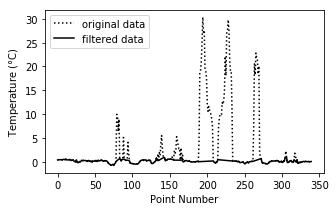

In [22]:
# Given the radiometer's accuracy, what is the upper threshold we're willing to accept as snow surface temperature?
upper_threshold = 1
plt.figure(figsize=(5,3))
# plot original data points
plt.plot(transect.matched_temperature,':k',label='original data')
# Filter out all points > upper_threshold
transect = transect[transect.matched_temperature<upper_threshold]
# plot filtered data points
plt.plot(transect.matched_temperature,'-k',label='filtered data')
# format plot
plt.xlabel('Point Number')
plt.ylabel('Temperature ($\degree$C)')
plt.legend()
# How many points do each transect have?
print('Count by',transect.groupby('transect').matched_temperature.count())

#### Compute summary statistics by transect:

In [23]:
# Summary stats grouped by transect:
print('Mean by',transect.groupby('transect').matched_temperature.mean())
print('Median by',transect.groupby('transect').matched_temperature.median())
print('Standard Deviation by',transect.groupby('transect').matched_temperature.std())
print('Max by',transect.groupby('transect').matched_temperature.max())
print('Min by',transect.groupby('transect').matched_temperature.min())

Mean by transect
center   -0.029783
east      0.295250
north     0.094981
south     0.044879
west      0.272038
Name: matched_temperature, dtype: float64
Median by transect
center   -0.0025
east      0.3010
north     0.0665
south     0.2045
west      0.2975
Name: matched_temperature, dtype: float64
Standard Deviation by transect
center    0.213362
east      0.326377
north     0.218126
south     0.383257
west      0.183890
Name: matched_temperature, dtype: float64
Max by transect
center    0.693
east      0.930
north     0.916
south     0.715
west      0.567
Name: matched_temperature, dtype: float64
Min by transect
center   -0.484
east     -0.347
north    -0.309
south    -0.736
west     -0.177
Name: matched_temperature, dtype: float64


#### Map the path of these transects, and plot their temperatures:

In [24]:
# Create geometry objects from the UTM coordinates
geometry = [Point(xy) for xy in zip(transect.UTM_easting, transect.UTM_northing)]
# Specify the UTM coordinate system
crs = {'init': 'epsg:26910'}
# Create geopandas dataframe with the geometry information
transects = gpd.GeoDataFrame(transect, crs=crs, geometry=geometry)

In [25]:
# Preview the first few rows of data
transects.head()

,Year,month,day,hour,minute,second,Datetime,sensor_ID,latitude,longitude,UTM_easting,UTM_northing,matched_temperature,transect,geometry
0,2017,4,21,11,47,0,4/21/17 11:47:00,5909,39.431942,-120.239566,737588.6,4368348.3,0.407,west,POINT (737588.6 4368348.3)
1,2017,4,21,11,47,30,4/21/17 11:47:30,5909,39.431940,-120.239573,737588.1,4368348.0,0.457,west,POINT (737588.1 4368348)
2,2017,4,21,11,48,0,4/21/17 11:48:00,5909,39.431938,-120.239580,737587.5,4368347.8,0.462,west,POINT (737587.5 4368347.8)
3,2017,4,21,11,48,30,4/21/17 11:48:30,5909,39.431936,-120.239587,737586.9,4368347.6,0.431,west,POINT (737586.9 4368347.6)
4,2017,4,21,11,49,0,4/21/17 11:49:00,5909,39.431934,-120.239593,737586.3,4368347.3,0.473,west,POINT (737586.3 4368347.3)


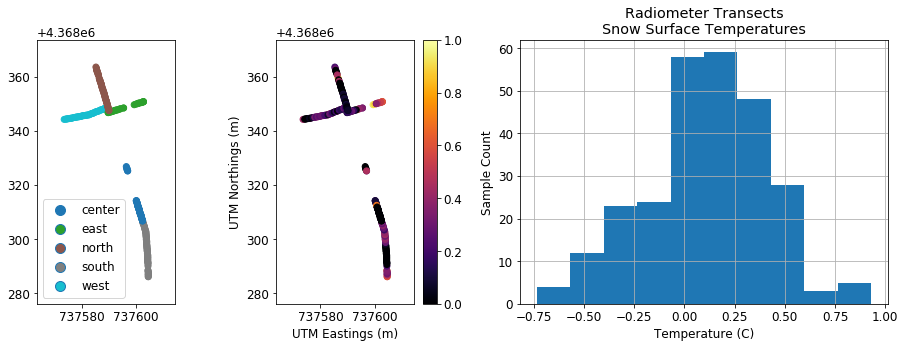

In [43]:
fig, ax = plt.subplots(1,3,
                       figsize=(13,5),
                       gridspec_kw={'width_ratios': [1, 1, 2]})
# plot the points colored by which transect they belong to
transects.plot(ax=ax[0], column='transect', legend=True)
buffer = 10
ax[0].set_xlim((transects.total_bounds[0]-buffer,transects.total_bounds[2]+buffer))
ax[0].set_ylim((transects.total_bounds[1]-buffer,transects.total_bounds[3]+buffer))
#ax[0].set_title('Radiometer Transects')

# plot the points colored by their temperature
transects.plot(ax=ax[1], 
               column='matched_temperature', 
               cmap='inferno', 
               vmin=0, vmax=1,
               legend=True)
ax[1].set_xlim((transects.total_bounds[0]-buffer,transects.total_bounds[2]+buffer))
ax[1].set_xlabel('UTM Eastings (m)')
ax[1].set_ylim((transects.total_bounds[1]-buffer,transects.total_bounds[3]+buffer))
ax[1].set_ylabel('UTM Northings (m)')
#ax[1].set_title('Point Temperatures')

# plot a histogram of all surface temperatures recorded across all transects
transects.hist(ax=ax[2],column='matched_temperature')
ax[2].set_xlabel('Temperature (C)')
ax[2].set_ylabel('Sample Count')
ax[2].set_title('Radiometer Transects\nSnow Surface Temperatures')
fig.tight_layout()

Text(0.5,1,'Radiometer Transects\nSnow Surface Temperatures')

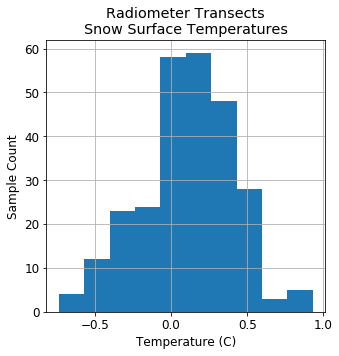

In [44]:
# Figure S3c histogram
fig, ax = plt.subplots(figsize=(5,5))
transects.hist(ax=ax,column='matched_temperature')
ax.set_xlabel('Temperature (C)')
ax.set_ylabel('Sample Count')
ax.set_title('Radiometer Transects\nSnow Surface Temperatures')
#fig.savefig('radiometer_transect_tss.png',dpi=600)

#### Plot Temperature Across N-S and E-W Transects:

Text(0.5,0,'UTM Northings (m)\n[zone 10N]')

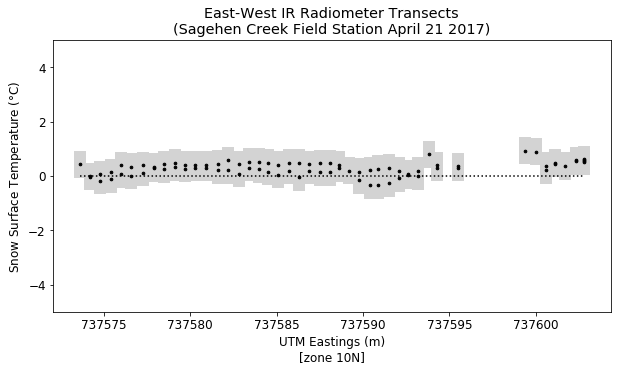

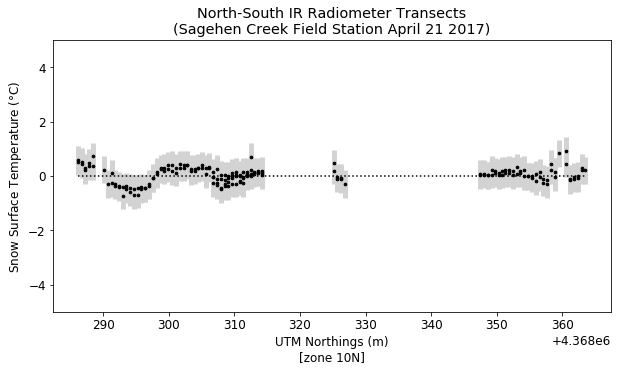

In [85]:
error = 0.5

fig, ax = plt.subplots(figsize=(10,5))
EW_transects = transects[(transects.transect != 'north') & (transects.transect != 'south') & (transects.transect != 'center')]
ax.errorbar(EW_transects.UTM_easting,EW_transects.matched_temperature,yerr=error, 
            fmt='.', c='lightgray',linewidth=12, label='IR Radiometer Error Bounds',zorder=0)
ax.scatter(EW_transects.UTM_easting, EW_transects.matched_temperature,c='k',s=7,zorder=1)
ax.plot(np.linspace(EW_transects.UTM_easting.min(),EW_transects.UTM_easting.max(),2),np.linspace(0,0,2),':k')
ax.set_ylim((-5,5))
plt.title('East-West IR Radiometer Transects\n(Sagehen Creek Field Station April 21 2017)')
plt.ylabel('Snow Surface Temperature ($\degree$C)')
plt.xlabel('UTM Eastings (m)\n[zone 10N]')
#plt.savefig('EW_InSituTransectsSagehen.png',dpi=600)

fig, ax = plt.subplots(figsize=(10,5))
NS_transects = transects[(transects.transect != 'east') & (transects.transect != 'west')]
ax.scatter(NS_transects.UTM_northing, NS_transects.matched_temperature,c='k',s=7)
ax.errorbar(NS_transects.UTM_northing,NS_transects.matched_temperature,yerr=error, 
            fmt='.', c='lightgray',linewidth=5, label='IR Radiometer Error Bounds',zorder=0)
ax.plot(np.linspace(NS_transects.UTM_northing.min(),NS_transects.UTM_northing.max(),2),np.linspace(0,0,2),':k')
ax.set_ylim((-5,5))
plt.title('North-South IR Radiometer Transects\n(Sagehen Creek Field Station April 21 2017)')
plt.ylabel('Snow Surface Temperature ($\degree$C)')
plt.xlabel('UTM Northings (m)\n[zone 10N]')
#plt.savefig('NS_InSituTransectsSagehen.png',dpi=600)


***
## Sagehen Creek: Fixed IR Radiometer Data:

In [133]:
# We only want to compute these for the same time as the transect measurements were taken
startdate = dt.strptime(transect.Datetime.min(),'%m/%d/%y %H:%M:%S')
enddate = dt.strptime(transect.Datetime.max(),'%m/%d/%y %H:%M:%S')
# Or compute for a different time range:
#startdate = dt(2017, 4, 21, 9, 0, 0)
#enddate = dt(2017, 4, 21, 16, 0, 0)

#### Take 10 minute averages of Tss and Tf time series:

In [115]:
# Fixed radiometer measurements of the open meadow snow surface
# Take an average  every 10 minutes to smooth out the plot:
tss_time10min = [];
tss_mean10min = [];
tf_mean10min = [];
for t in range(0,len(trees_datetime)):
    if (t+1)%10==0:
        tss_time10min.append(trees_datetime[t-5])
        tss_mean10min.append(np.mean(trees_data['tempC_6363_meadow_snow'][t-9:t]))
        tf_mean10min.append(np.mean(trees_data['tempC_6433_tree'][t-9:t]))

# Make a pandas dataframe of the above 10 min mean data   
fixed10min = pd.DataFrame({'time':tss_time10min, 'Tss':tss_mean10min, 'Tf':tf_mean10min})

#### Plot the timeseries of surface temperature measurements:

Text(0,0.5,'Temperature, $\\degree$C')

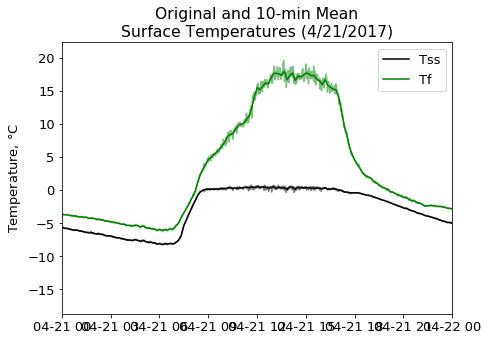

In [123]:
# Plot both the original and 10-minute averaged data
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(trees_datetime,trees_data['tempC_6363_meadow_snow'],'k',alpha=0.5)
ax.plot(trees_datetime,trees_data['tempC_6433_tree'],'g',alpha=0.5)
ax.plot(fixed10min.time,fixed10min.Tss,'k',label='Tss')
ax.plot(fixed10min.time,fixed10min.Tf,'g',label='Tf')
ax.set_xlim(('2017-04-21','2017-04-22'))
plt.legend()
ax.set_title('Original and 10-min Mean\nSurface Temperatures (4/21/2017)')
ax.set_ylabel('Temperature, $\degree$C')

#### Compute summary statistics for fixed radiometer:

In [124]:
# Summary stats for fixed radiometer:
print('Mean',fixed10min[(fixed10min.time>startdate) & (fixed10min.time<enddate)].Tss.mean())
print('Median',fixed10min[(fixed10min.time>startdate) & (fixed10min.time<enddate)].Tss.median())
print('Standard Deviation',fixed10min[(fixed10min.time>startdate) & (fixed10min.time<enddate)].Tss.std())
print('Max',fixed10min[(fixed10min.time>startdate) & (fixed10min.time<enddate)].Tss.max())
print('Min',fixed10min[(fixed10min.time>startdate) & (fixed10min.time<enddate)].Tss.min())

Mean 0.3350130718954249
Median 0.3528888888888889
Standard Deviation 0.1182454820760982
Max 0.5006666666666667
Min 0.06355555555555553


#### Comparison between Transect and Fixed radiometer snow surface temperature measurements:

In [125]:
def rmse(value, predictions):
    error = predictions - value
    SE = error**2
    MSE = np.mean(SE)
    RMSE = np.sqrt(MSE)
    mean_bias = np.mean(error)
    return RMSE, mean_bias

fixed_mean_Tss = fixed10min[(fixed10min.time>startdate) & (fixed10min.time<enddate)].Tss.mean()
# Calculate RMSE for each transect against mean fixed radiometer snow surface temperature:
north_rmse, north_bias = rmse(fixed_mean_Tss, transect[transect['transect']=='north'].matched_temperature)
east_rmse, east_bias = rmse(fixed_mean_Tss, transect[transect['transect']=='east'].matched_temperature)
west_rmse, west_bias = rmse(fixed_mean_Tss, transect[transect['transect']=='west'].matched_temperature)
center_rmse, center_bias = rmse(fixed_mean_Tss, transect[transect['transect']=='center'].matched_temperature)
south_rmse, south_bias = rmse(fixed_mean_Tss, transect[transect['transect']=='south'].matched_temperature)

# Print RMSE and Mean Bias:
print('Transect | RMSE | Mean Bias')
print('North:',north_rmse, north_bias)
print('East:',east_rmse, east_bias)
print('West:',west_rmse, west_bias)
print('Center:',center_rmse, center_bias)
print('South:',south_rmse, south_bias)

Transect | RMSE | Mean Bias
North: 0.3229749978541632 -0.2400315904139434
East: 0.323688375426985 -0.039763071895424884
West: 0.19269423785129294 -0.06297461035696336
Center: 0.42171201112059864 -0.3647964052287582
South: 0.4783707610621339 -0.29013428401663705


#### Plot to compare Tss timeline to Tss transects:

Text(0.5,0,'Time')

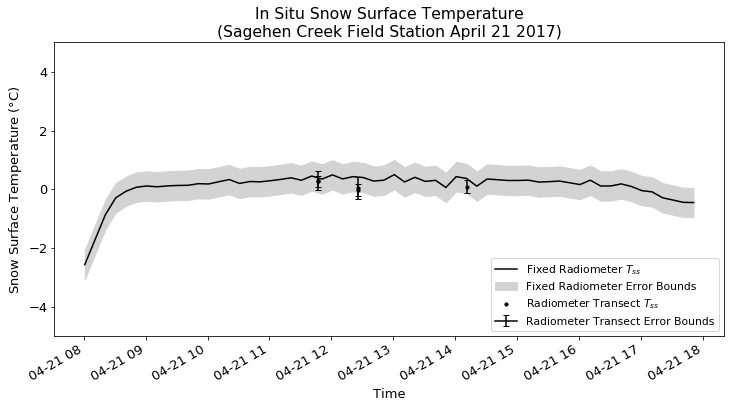

In [134]:
plt.rcParams.update({'font.size': 13})
# Time range for plot
plotstartdate = dt(2017, 4, 21, 8, 0, 0)
plotenddate = dt(2017, 4, 21, 18, 0, 0)

fig, ax = plt.subplots(figsize=(12,6))
# plot timeline of Tss at Sagehen for 4/21/2017
fixed10min[(fixed10min.time>plotstartdate) & (fixed10min.time<plotenddate)].plot(ax=ax, x='time', y='Tss', 
                                                                                 label='Fixed Radiometer $T_{ss}$',
                                                                                c='k')
# plot filled area to represent fixed radiometer accuracy
error = 0.5;
x = fixed10min[(fixed10min.time>plotstartdate) & (fixed10min.time<plotenddate)]['time'].values
y = fixed10min[(fixed10min.time>plotstartdate) & (fixed10min.time<plotenddate)]['Tss']
plt.fill_between(x, y-error, y+error, label='Fixed Radiometer Error Bounds', color='lightgray')


ax.set_ylim((-5,5))

# plot each transect mean and standard deviation as error bars at its start time:
# North
ax.scatter(transect[transect['transect']=='north'].Datetime.iloc[0],
            transect[transect['transect']=='north'].matched_temperature.mean(),s=10,c='k',
          label='Radiometer Transect $T_{ss}$')#label='North Transect $T_{ss}$')
ax.errorbar([transect[transect['transect']=='north'].Datetime.iloc[0]],
            [transect[transect['transect']=='north'].matched_temperature.mean()],
            yerr=transect[transect['transect']=='north'].matched_temperature.std(),
           fmt='-',c='k', capsize=3,
           label='Radiometer Transect Error Bounds')

# South
ax.scatter(transect[transect['transect']=='south'].Datetime.iloc[0],
            transect[transect['transect']=='south'].matched_temperature.mean(),s=10,c='k',
          )#label='South Transect $T_{ss}$')
ax.errorbar([transect[transect['transect']=='south'].Datetime.iloc[0]],
            [transect[transect['transect']=='south'].matched_temperature.mean()],
            yerr=transect[transect['transect']=='south'].matched_temperature.std(),
           fmt='-',c='k', capsize=3)

# East
ax.scatter(transect[transect['transect']=='east'].Datetime.iloc[0],
            transect[transect['transect']=='east'].matched_temperature.mean(),s=10,c='k',
          )#label='East Transect $T_{ss}$')
ax.errorbar([transect[transect['transect']=='east'].Datetime.iloc[0]],
            [transect[transect['transect']=='east'].matched_temperature.mean()],
            yerr=transect[transect['transect']=='east'].matched_temperature.std(),
           fmt='-', c='k', capsize=3)

# West
ax.scatter(transect[transect['transect']=='west'].Datetime.iloc[0],
            transect[transect['transect']=='west'].matched_temperature.mean(),s=10,c='k',
          )#label='West Transect $T_{ss}$')
ax.errorbar([transect[transect['transect']=='west'].Datetime.iloc[0]],
            [transect[transect['transect']=='west'].matched_temperature.mean()],
            yerr=transect[transect['transect']=='west'].matched_temperature.std(),
           fmt='-', c='k', capsize=3)

# Center
ax.scatter(transect[transect['transect']=='center'].Datetime.iloc[0],
            transect[transect['transect']=='center'].matched_temperature.mean(),s=10,c='k',
          )#label='Center Transect $T_{ss}$')
ax.errorbar([transect[transect['transect']=='center'].Datetime.iloc[0]],
            [transect[transect['transect']=='center'].matched_temperature.mean()],
            yerr=transect[transect['transect']=='center'].matched_temperature.std(),
           fmt='-',c='k', capsize=3)


fontP = FontProperties()
fontP.set_size('small')
ax.legend(loc='lower right',prop=fontP)


plt.title('In Situ Snow Surface Temperature\n(Sagehen Creek Field Station April 21 2017)')
plt.ylabel('Snow Surface Temperature ($\degree$C)')
plt.xlabel('Time')
#plt.savefig('InSituTssSagehen.png',dpi=600)

### Read in Sagehen Creek water temperature data:

In [135]:
stream_file = r'C:\Users\steve\OneDrive\Documents\School Stuff\UW\Mountain Hydrology Research Group\Sagehen_IR_project\Sagehen Creek Data\sagehen_creek.txt'
stream_data = pd.read_csv(stream_file,delimiter='\t')
stream_data['datetime'] =  pd.to_datetime(stream_data['datetime'], format='%Y/%m/%d %H:%M')

Text(0.5,0,'Hour of Day (UTC-7) on 4/21/2017')

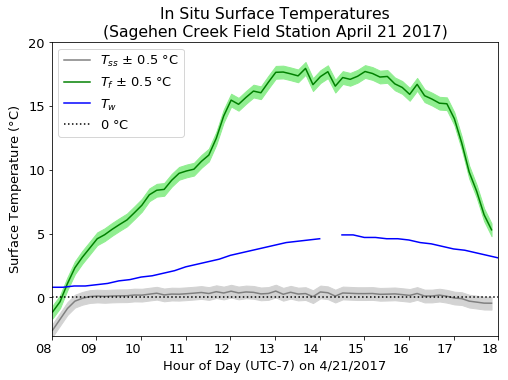

In [136]:
# Figure S3a
plt.rcParams.update({'font.size': 13})
# Time range for plot
plotstartdate = dt(2017, 4, 21, 8, 0, 0)
plotenddate = dt(2017, 4, 21, 18, 0, 0)

fig, ax = plt.subplots(figsize=(8,6))

########### Snow Surface Temperature ##############
# plot timeline of Tss at Sagehen for 4/21/2017
fixed10min[(fixed10min.time>plotstartdate) & (fixed10min.time<plotenddate)].plot(ax=ax, x='time', y='Tss', 
                                                                                 label='$T_{ss}$ $\pm$ 0.5 $\degree$C',
                                                                                c='gray')
# plot filled area to represent fixed radiometer accuracy
error = 0.5;
x = fixed10min[(fixed10min.time>plotstartdate) & (fixed10min.time<plotenddate)]['time'].values
y = fixed10min[(fixed10min.time>plotstartdate) & (fixed10min.time<plotenddate)]['Tss']
plt.fill_between(x, y-error, y+error, color='lightgray')

########### Canopy Surface Temperature ##############
# plot timeline of Tf at Sagehen for 4/21/2017
fixed10min[(fixed10min.time>plotstartdate) & (fixed10min.time<plotenddate)].plot(ax=ax, x='time', y='Tf', 
                                                                                 label='$T_{f}$ $\pm$ 0.5 $\degree$C',
                                                                                c='green')
# plot filled area to represent fixed radiometer accuracy
error = 0.5;
x = fixed10min[(fixed10min.time>plotstartdate) & (fixed10min.time<plotenddate)]['time'].values
y = fixed10min[(fixed10min.time>plotstartdate) & (fixed10min.time<plotenddate)]['Tf']
plt.fill_between(x, y-error, y+error, color='lightgreen')


########### Water Temperature ##############
# plot timeline of Tw at Sagehen for 4/21/2017
ax.plot(stream_data['datetime'],
        stream_data['temperature_C'],
        label='$T_{w}$',c='blue')


# plot a line at zero
plt.plot([plotstartdate,plotenddate],[0,0],':k',label='0 $\degree$C')

#ax.set_ylim((-1.5,1))
ax.set_ylim((-3,20))
ax.set_xlim((plotstartdate,plotenddate))
# matplotlib date format object
hfmt = dates.DateFormatter('%H')
ax.xaxis.set_major_locator(dates.HourLocator())
ax.xaxis.set_major_formatter(hfmt)
plt.xticks(rotation='horizontal')

fontP = FontProperties()
fontP.set_size('medium')
ax.legend(loc='upper left',prop=fontP)

plt.title('In Situ Surface Temperatures\n(Sagehen Creek Field Station April 21 2017)')
plt.ylabel('Surface Temperature ($\degree$C)')
plt.xlabel('Hour of Day (UTC-7) on 4/21/2017')
#plt.savefig('InSituSurfaceTempsSagehen.png',dpi=600)

***
## Davos: Fixed IR Radiometer Data:

#### Set filepaths to data:

In [137]:
# Forested site data:
forest_site = r'C:\Users\steve\OneDrive\Documents\School Stuff\UW\Mountain Hydrology Research Group\Sagehen_IR_project\Davos in situ data\SLFSHD_ForestStation_20170327.csv'
# Open site data:
open_site = r'C:\Users\steve\OneDrive\Documents\School Stuff\UW\Mountain Hydrology Research Group\Sagehen_IR_project\Davos in situ data\SLFSHD_OpenStation_20170327.csv'

#### Read in in situ data:

In [138]:
# Forested site
forest_data = pd.read_csv(forest_site,delimiter=',')
# Fix datetime formats
forest_data['TIMESTAMP'] =  pd.to_datetime(forest_data['TIMESTAMP'], format='%d.%m.%Y %H:%M:%S')

# Open site
open_data = pd.read_csv(open_site,delimiter=',')
# Fix datetime formats
open_data['TIMESTAMP'] =  pd.to_datetime(open_data['TIMESTAMP'], format='%d.%m.%Y %H:%M:%S')

#### Set time range to that of the drone flights:

In [139]:
# Flight #1: 13:57:40 - 14:02:05
# Flight #2: 14:11:40 - 14:14:05
startdatetime = dt(2017, 3, 27, 9, 0, 0)
enddatetime = dt(2017, 3, 27, 16, 0, 0)

#### Summary stats for Open site:

In [140]:
# Summary stats for open site fixed radiometer:
print('Mean',open_data[(open_data.TIMESTAMP>=startdatetime) & (open_data.TIMESTAMP<=enddatetime)]['TSS (DegC)'].mean())
print('Median',open_data[(open_data.TIMESTAMP>=startdatetime) & (open_data.TIMESTAMP<=enddatetime)]['TSS (DegC)'].median())
print('Standard Deviation',open_data[(open_data.TIMESTAMP>=startdatetime) & (open_data.TIMESTAMP<=enddatetime)]['TSS (DegC)'].std())
print('Max',open_data[(open_data.TIMESTAMP>=startdatetime) & (open_data.TIMESTAMP<=enddatetime)]['TSS (DegC)'].max())
print('Min',open_data[(open_data.TIMESTAMP>=startdatetime) & (open_data.TIMESTAMP<=enddatetime)]['TSS (DegC)'].min())

Mean -0.6241999999999999
Median -0.579
Standard Deviation 0.253205788694831
Max -0.313
Min -1.4609999999999999


#### Summary stats for Forested site:

In [141]:
# Summary stats for forested site fixed radiometer:
print('Mean',forest_data[(forest_data.TIMESTAMP>=startdatetime) & (forest_data.TIMESTAMP<=enddatetime)]['TSS (DegC)'].mean())
print('Median',forest_data[(forest_data.TIMESTAMP>=startdatetime) & (forest_data.TIMESTAMP<=enddatetime)]['TSS (DegC)'].median())
print('Standard Deviation',forest_data[(forest_data.TIMESTAMP>=startdatetime) & (open_data.TIMESTAMP<=enddatetime)]['TSS (DegC)'].std())
print('Max',forest_data[(forest_data.TIMESTAMP>=startdatetime) & (forest_data.TIMESTAMP<=enddatetime)]['TSS (DegC)'].max())
print('Min',open_data[(forest_data.TIMESTAMP>=startdatetime) & (forest_data.TIMESTAMP<=enddatetime)]['TSS (DegC)'].min())

Mean 0.031066666666666694
Median -0.006999999999999999
Standard Deviation 0.26067288386203963
Max 0.56
Min -1.4609999999999999


#### Plot Tss at Davos:

Text(0.5,0,'Time')

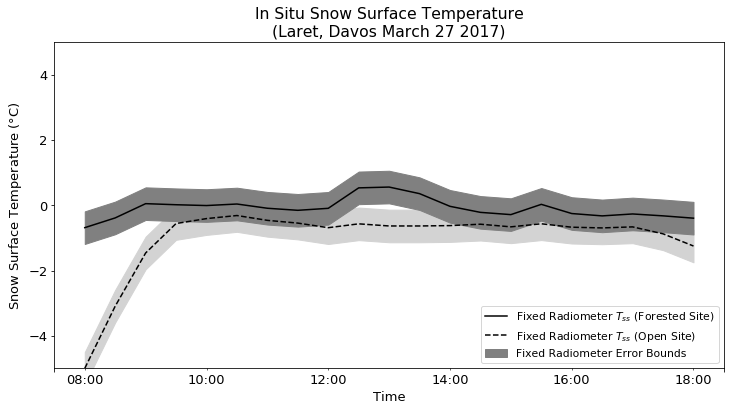

In [143]:
plt.rcParams.update({'font.size': 13})
# Time range for plot
startdatetime = dt(2017, 3, 27, 8, 0, 0)
enddatetime = dt(2017, 3, 27, 18, 0, 0)

fig, ax = plt.subplots(figsize=(12,6))
# plot timeline of forest site Tss at Davos for 3/27/2017
forest_data[(forest_data.TIMESTAMP>=startdatetime) & (forest_data.TIMESTAMP<=enddatetime)].plot(ax=ax, x='TIMESTAMP', y='TSS (DegC)', 
                                                                                 label='Fixed Radiometer $T_{ss}$ (Forested Site)',
                                                                                c='k')
open_data[(open_data.TIMESTAMP>=startdatetime) & (open_data.TIMESTAMP<=enddatetime)].plot(ax=ax, x='TIMESTAMP', y='TSS (DegC)', 
                                                                                 label='Fixed Radiometer $T_{ss}$ (Open Site)',
                                                                                linestyle='--',c='k')

# plot filled area to represent fixed radiometer accuracy
error = 0.5;

x = open_data[(open_data.TIMESTAMP>=startdatetime) & (open_data.TIMESTAMP<=enddatetime)]['TIMESTAMP'].values
y = open_data[(open_data.TIMESTAMP>=startdatetime) & (open_data.TIMESTAMP<=enddatetime)]['TSS (DegC)']
plt.fill_between(x, y-error, y+error, color='lightgray')

x = forest_data[(forest_data.TIMESTAMP>=startdatetime) & (forest_data.TIMESTAMP<=enddatetime)]['TIMESTAMP'].values
y = forest_data[(forest_data.TIMESTAMP>=startdatetime) & (forest_data.TIMESTAMP<=enddatetime)]['TSS (DegC)']
plt.fill_between(x, y-error, y+error, label='Fixed Radiometer Error Bounds', color='gray')



ax.set_ylim((-5,5))


fontP = FontProperties()
fontP.set_size('small')
ax.legend(loc='lower right',prop=fontP)


plt.title('In Situ Snow Surface Temperature\n(Laret, Davos March 27 2017)')
plt.ylabel('Snow Surface Temperature ($\degree$C)')
plt.xlabel('Time')
#plt.savefig('InSituTssDavos.png',dpi=600)